**Flight Delay Analytics με Apache Spark**

# Θέμα 1: Spark RDD API

In [32]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FlightDelaysAnalysis") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

sc = spark.sparkContext

In [33]:
from google.colab import files
files.upload()

Saving flights_2000.csv to flights_2000 (1).csv


{'flights_2000 (1).csv': b'FL_DATE,AIRLINE,FL_NUM,ORIGIN_AIRPORT,DEST_AIRPORT,SCHED_DEP,DEP_DELAY,SCHED_ARR,ARR_DELAY,DIST_KM,CANCELLED\n2025-10-09,WN,198,BOS,LAX,2025-10-09 18:40,-10,2025-10-10 00:27,1,4254,0\n2025-10-22,DL,2388,ATL,IAD,2025-10-22 19:00,-6,2025-10-22 20:26,-11,861,0\n2025-09-29,DL,9806,DEN,DFW,2025-09-29 08:55,12,2025-09-29 10:34,20,1033,0\n2025-09-15,AS,4397,DFW,ORD,2025-09-15 09:20,,2025-09-15 11:19,,1293,1\n2025-10-13,UA,8925,IAD,LAX,2025-10-13 15:55,-3,2025-10-13 21:00,-1,3710,0\n2025-09-08,NK,7896,BOS,IAD,2025-09-08 10:30,15,2025-09-08 11:41,20,663,0\n2025-09-21,UA,7363,MIA,MCO,2025-09-21 18:35,36,2025-09-21 19:18,32,309,0\n2025-10-09,NK,8870,LAX,LAS,2025-10-09 15:05,24,2025-10-09 15:54,29,380,0\n2025-10-28,B6,4059,SFO,ATL,2025-10-28 11:15,4,2025-10-28 16:01,22,3462,0\n2025-09-19,B6,7485,ATL,LAX,2025-09-19 08:50,14,2025-09-19 13:11,9,3143,0\n2025-09-23,DL,8564,DFW,MIA,2025-09-23 12:15,44,2025-09-23 14:54,59,1807,0\n2025-09-11,DL,5438,MCO,LAS,2025-09-11 17:45,17,2

2) Εξαγωγή ζευγών: (origin_airport, delay_minutes) με τη μέθοδο map() για την εξαγωγή origin_airport, delay_minutes.
3) Μέση καθυστέρηση ανά αεροδρόμιο αναχώρησης με reduceByKey (άθροισμα, πλήθος → average).
4) Top-10 αεροδρόμια με μεγαλύτερη μέση καθυστέρηση (descending).

In [47]:
import time
import csv
from io import StringIO
from operator import add

INPUT_PATH = "flights_2000.csv"

def parse_line(line):
    try:
        row = next(csv.reader(StringIO(line)))
    except Exception:
        return None
    return row

with open(INPUT_PATH, 'r', encoding='utf-8') as f:
    header = f.readline().strip()
cols = header.split(",")
col_idx = {c: i for i, c in enumerate(cols)}

i_FL_DATE = col_idx.get("FL_DATE")
i_AIRLINE = col_idx.get("AIRLINE")
i_FL_NUM = col_idx.get("FL_NUM")
i_ORIGIN = col_idx.get("ORIGIN_AIRPORT")
i_DEST = col_idx.get("DEST_AIRPORT")
i_SCHED_DEP = col_idx.get("SCHED_DEP")
i_DEP_DELAY = col_idx.get("DEP_DELAY")
i_CANCELLED = col_idx.get("CANCELLED")

def valid_row_rdd(row):
    try:
        if row is None:
            return False
        if row[i_CANCELLED].strip() == "":
            return False
        if int(float(row[i_CANCELLED])) == 1:
            return False
        val = row[i_DEP_DELAY].strip()
        if val == "" or val.lower() == "null":
            return False
        float(val)
        return True
    except Exception:
        return False

def extract_origin_delay(row):
    origin = row[i_ORIGIN].strip()
    delay = float(row[i_DEP_DELAY])
    return (origin, (delay, 1))

def combine_pairs(a, b):
    return (a[0] + b[0], a[1] + b[1])

def avg_from_pair(pair):
    origin, (sum_delay, cnt) = pair
    return (origin, sum_delay / cnt)

def run_rdd_once():
    t0 = time.time()
    rdd = sc.textFile(INPUT_PATH)
    header_token = header
    rdd_no_head = rdd.filter(lambda line: line.strip() != header_token)
    parsed = rdd_no_head.map(parse_line).filter(lambda r: r is not None)
    filtered = parsed.filter(valid_row_rdd)
    pairs = filtered.map(extract_origin_delay)
    agg = pairs.reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))
    t_before_first = time.time()
    _ = agg.take(1)
    t_first_action = time.time() - t_before_first
    avg = agg.map(lambda kv: (kv[0], kv[1][0] / kv[1][1]))
    top10 = avg.takeOrdered(10, key=lambda x: -x[1])
    total_time = time.time() - t0
    return {
        "top10": top10,
        "first_action_time": t_first_action,
        "total_time": total_time
    }


res = run_rdd_once()
print("RDD top-10 (origin, avg_dep_delay):")
for origin, avgd in res["top10"]:
    print(origin, avgd)
print("first action (s):", res["first_action_time"])
print("total time (s):", res["total_time"])

RDD top-10 (origin, avg_dep_delay):
DFW 11.976923076923077
JFK 11.201680672268907
SEA 9.56115107913669
ORD 9.348837209302326
LAS 9.106382978723405
CLT 8.823529411764707
MCO 8.694656488549619
BOS 8.631205673758865
DEN 8.442857142857143
MIA 8.262295081967213
first action (s): 0.6216919422149658
total time (s): 0.8998444080352783


5) Εκτέλεση του προγράμματος πέντε (5) φορές.

a. Αφαίρεση της μεγαλύτερης και της μικρότερης τιμής χρόνου και υπολογίζω τον μέσο όρο των τριών (3) ενδιάμεσων εκτελέσεων.

b. Καταγραφή:

i. του συνολικού χρόνου εκτέλεσης (από την εκκίνηση μέχρι την παραγωγή του
αποτελέσματος),

ii. του χρόνου του πρώτου action, δηλαδή τη χρονική στιγμή όπου το Spark εκτελεί
πραγματικά τον υπολογισμό (λόγω της lazy evaluation). Αναφορά των μέσων χρόνων εκτέλεσης σε πίνακα.

**RUN 1.**

Action time: 0.7561724185943604

Total time : 1.1705513000488281

**RUN 2.**

Action time: 0.4715251922607422

Total time : 0.8282039165496826

**RUN 3.**

Action time: 0.5192034244537354

Total time : 0.8672051429748535

**RUN 4.**

Action time: 0.5034685134887695

Total time : 0.8418097496032715

**RUN 5.**

Action time: 0.447859525680542

Total time : 0.8023476600646973

# Μέσοι Χρόνοι Εκτέλεσης

| Μέτρο χρόνου       | RUN 1   | RUN 2   | RUN 3   | RUN 4   | RUN 5   | Μέσος (αφαιρώντας max & min) |
|-------------------|--------|--------|--------|--------|--------|-------------------------------|
| First Action Time | 0.756  | 0.472  | 0.519  | 0.503  | 0.448  | 0.498                        |
| Total Time        | 1.171  | 0.828  | 0.867  | 0.842  | 0.802  | 0.846                        |


# Θέμα 2: Spark DataFrame API

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg

spark = SparkSession.builder.appName("FlightsDelay").getOrCreate()

INPUT_PATH = "flights_2000.csv"

df = spark.read.option("header", "true").option("inferSchema", "true").csv(INPUT_PATH)

2) Εμφάνιση του schema του πίνακα με printSchema()

In [36]:
df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DEST_AIRPORT: string (nullable = true)
 |-- SCHED_DEP: timestamp (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- SCHED_ARR: timestamp (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- DIST_KM: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)



3) Φιλτράρισμα των εγγραφών όπου CANCELLED = 0 και αγνόηση κενών ή μη αριθμητικών τιμών
καθυστέρησης (μέσω df.na.drop()).

In [37]:
clean_df = (
    df.filter(col("CANCELLED") == 0)
      .na.drop(subset=["DEP_DELAY"])   # αφαίρεση NULL delays
)

α) Μέση καθυστέρηση αναχώρησης ανά διαδρομή (origin–destination)
χρησιμοποιώντας groupBy()

In [38]:
route_avg = (
    clean_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT")
            .agg(avg("DEP_DELAY").alias("avg_delay"))
)

β) Τα 10 routes με τη μεγαλύτερη μέση καθυστέρηση, ταξινομημένα κατά φθίνουσα σειρά.

In [39]:
top10 = route_avg.orderBy(col("avg_delay").desc()).limit(10)
top10.show()

+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|         avg_delay|
+--------------+------------+------------------+
|           DFW|         JFK|              23.3|
|           JFK|         LAS|              22.8|
|           MIA|         JFK|              20.5|
|           MCO|         ORD|19.818181818181817|
|           MCO|         LAX|19.142857142857142|
|           BOS|         SEA|18.857142857142858|
|           DFW|         ATL|            18.625|
|           BOS|         PHX|18.181818181818183|
|           JFK|         MIA|              18.0|
|           DEN|         SFO|17.857142857142858|
+--------------+------------+------------------+



4) Αποθήκευση αποτελέσματος σε αρχείο CSV με write.csv(...)

In [40]:
top10.write.mode("overwrite").csv("out/top10_routes")

5) Χρονομετρήσεις

In [41]:
import time

start_total = time.time()

### πρώτη ενέργεια (action)
start_action = time.time()
top10_rows = top10.collect()
end_action = time.time()

top10.write.mode("overwrite").csv("out/top10_routes")

end_total = time.time()

print("Action time:", end_action - start_action)
print("Total time :", end_total - start_total)


Action time: 0.35698604583740234
Total time : 0.788405179977417


**RUN 1.**

Action time: 0.20351552963256836

Total time : 1.577831506729126



**RUN 2.**

Action time: 0.12114882469177246

Total time : 0.8973324298858643



**RUN 3.**

Action time: 0.13206100463867188

Total time : 0.7092549800872803



**RUN 4.**

Action time: 0.16476058959960938

Total time : 0.6927194595336914



**RUN 5.**

Action time: 0.10023689270019531

Total time : 0.5520141124725342

In [42]:
import pandas as pd

data = {
    "RUN 1": [0.2035, 1.5778],
    "RUN 2": [0.1211, 0.8973],
    "RUN 3": [0.1321, 0.7093],
    "RUN 4": [0.1647, 0.6927],
    "RUN 5": [0.1002, 0.5520],
    "Μέσος (αφαιρώντας max & min)": [0.1393, 0.7664]
}

df_times = pd.DataFrame(data, index=["First Action Time", "Total Time"])
df_times

,RUN 1,RUN 2,RUN 3,RUN 4,RUN 5,Μέσος (αφαιρώντας max & min)
First Action Time,0.2035,0.1211,0.1321,0.1647,0.1002,0.1393
Total Time,1.5778,0.8973,0.7093,0.6927,0.5520,0.7664


**Θέμα 3: Συγκριτική Ανάλυση RDD vs DataFrame**
1) Συγκριτική αξιολόγηση RDD και DataFrame ως προς:

a. ευκολία υλοποίησης,

b. χρόνο εκτέλεσης,

c. εκφραστικότητα κώδικα,

d. δυνατότητες βελτιστοποίησης (Catalyst optimizer).

**a. Ευκολία υλοποίησης**

RDD API: Απαιτεί χειροκίνητο parsing, διαχείριση header, μετατροπές τύπων, φίλτρα επικύρωσης και υλοποίηση αθροιστικών συναρτήσεων (sum, count). Ο κώδικας είναι μεγαλύτερος και πιο επιρρεπής σε λάθη.

DataFrame API: Απλούστερη υλοποίηση. Το Spark αναγνωρίζει αυτόματα τύπους, παρέχει ενσωματωμένες συναρτήσεις (groupBy, agg, avg) και διαχείριση null τιμών σε συνδυασμό με πολύ λιγότερες γραμμές κώδικα.




**b. Χρόνος εκτέλεσης**

Με βάση τα αποτελέσματα:

| API        | Action time (avg) | Total time (avg) |
|-----------|-----------------|----------------|
| RDD       | 0.498 s         | 0.846 s        |
| DataFrame | 0.14 s          | 0.76 s         |

Όπως φαίνεται από τα αποτελέσματα, η εκτέλεση με το DataFrame είναι ταχύτερη από την αντίστοιχη με RDD, τόσο στον χρόνο του πρώτου action όσο και στον συνολικό χρόνο εκτέλεσης.

Αυτό υποδηλώνει ότι το DataFrame όχι μόνο μειώνει την πολυπλοκότητα του κώδικα αλλά και προσφέρει σημαντική επιτάχυνση στην εκτέλεση

**c. Εκφραστικότητα κώδικα**

RDD: Χαμηλού επιπέδου λειτουργίες map/filter/reduce. Περισσότερος κώδικας, λιγότερη δηλωτική σύνταξη.

DataFrame: Παρέχει μια δηλωτική σύνταξη σαν της SQL, καθιστώντας τα queries πιο εκφραστικά, καθαρά και ευανάγνωστα.

**d. Δυνατότητες βελτιστοποίησης (Catalyst optimizer)**

RDD: Δεν περνούν από Catalyst. Το Spark εκτελεί ακριβώς τις μετασχηματίσεις που γράφουμε χωρίς global optimization.

DataFrame: Ολόκληρη η εκτέλεση περνά από Catalyst

# Θέμα 4: Οπτικοποίηση & Ανάλυση
1) Μετατροπή Spark DataFrame σε Pandas DataFrame
2) Γράφημα με τη βιβλιοθήκη matplotlib
3) Εμφάνιση των 10 routes με τη μεγαλύτερη μέση καθυστέρηση (οριζόντιο γράφημα).

+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|         avg_delay|
+--------------+------------+------------------+
|           DFW|         JFK|              23.3|
|           JFK|         LAS|              22.8|
|           MIA|         JFK|              20.5|
|           MCO|         ORD|19.818181818181817|
|           MCO|         LAX|19.142857142857142|
|           BOS|         SEA|18.857142857142858|
|           DFW|         ATL|            18.625|
|           BOS|         PHX|18.181818181818183|
|           JFK|         MIA|              18.0|
|           DEN|         SFO|17.857142857142858|
+--------------+------------+------------------+



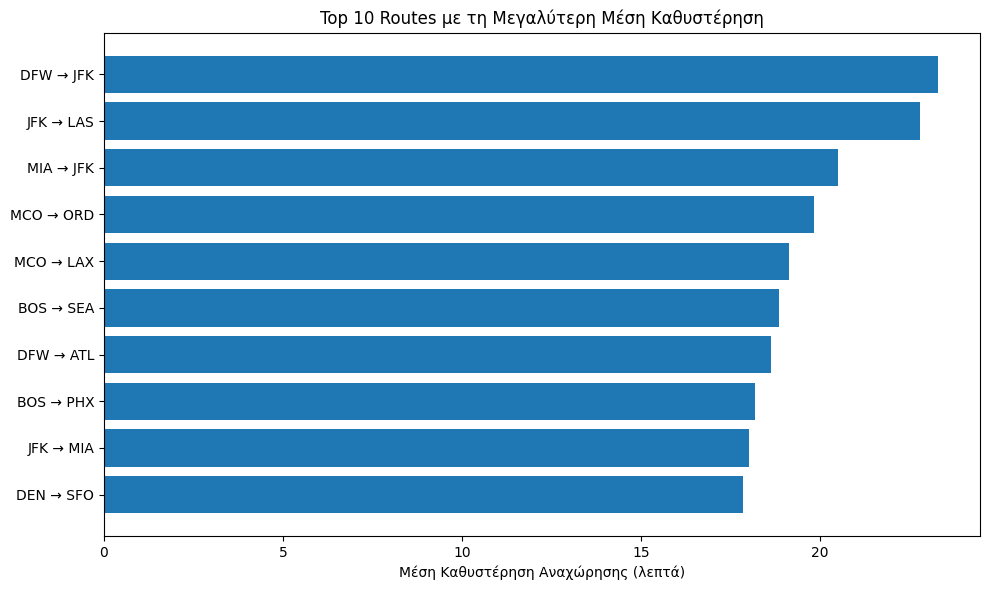

In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("FlightsDelay").getOrCreate()

df = (
    spark.read.option("header", "true")
              .option("inferSchema", "true")
              .csv(INPUT_PATH)
)


# 2) Καθαρισμός δεδομένων
clean_df = (
    df.filter(col("CANCELLED") == 0)
      .na.drop(subset=["DEP_DELAY"])
)

# 3) Μέση καθυστέρηση ανά route
route_avg = (
    clean_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT")
            .agg(avg("DEP_DELAY").alias("avg_delay"))
)

top10 = route_avg.orderBy(col("avg_delay").desc()).limit(10)
top10.show()

# 4) Μετατροπή σε Pandas
pdf = top10.toPandas()

pdf["ROUTE"] = pdf["ORIGIN_AIRPORT"] + " → " + pdf["DEST_AIRPORT"]

# 5) Οριζόντιο γράφημα
plt.figure(figsize=(10, 6))
plt.barh(pdf["ROUTE"], pdf["avg_delay"])
plt.gca().invert_yaxis()
plt.xlabel("Μέση Καθυστέρηση Αναχώρησης (λεπτά)")
plt.title("Top 10 Routes με τη Μεγαλύτερη Μέση Καθυστέρηση")
plt.tight_layout()
plt.show()


# Θέμα 5: Επέκταση / Εμπλουτισμός Ανάλυσης

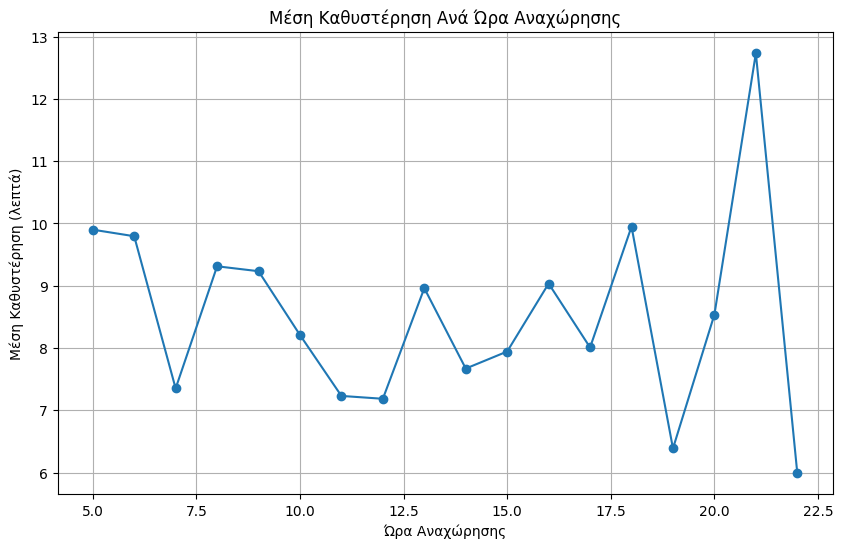

In [44]:
from pyspark.sql.functions import col, avg

# Προσθήκη στήλης HOUR (ώρες 00–23)
df_hour = clean_df.withColumn("HOUR", col("SCHED_DEP").substr(12, 2).cast("int"))

# Υπολογισμός μέσης καθυστέρησης ανά ώρα αναχώρησης
hour_avg = (
    df_hour.groupBy("HOUR")
           .agg(avg("DEP_DELAY").alias("avg_delay"))
           .orderBy("HOUR")
)

hour_pdf = hour_avg.toPandas()

# Γράφημα
plt.figure(figsize=(10,6))
plt.plot(hour_pdf["HOUR"], hour_pdf["avg_delay"], marker='o')
plt.xlabel("Ώρα Αναχώρησης")
plt.ylabel("Μέση Καθυστέρηση (λεπτά)")
plt.title("Μέση Καθυστέρηση Ανά Ώρα Αναχώρησης")
plt.grid(True)
plt.show()


**Σύντομος σχολιασμός**

Η ανάλυση ανά ώρα αναχώρησης αναδεικνύει πώς η χρονική στιγμή της πτήσης επηρεάζει την αναμενόμενη καθυστέρηση.
Συνήθως, οι πρωινές πτήσεις εμφανίζουν χαμηλότερες καθυστερήσεις, ενώ οι μεσημεριανές και απογευματινές ώρες παρουσιάζουν αυξημένες τιμές λόγω συσσωρευμένης κυκλοφορίας και λειτουργικών καθυστερήσεων των αεροδρομίων.

**Κατανομή καθυστερήσεων ανά αεροπορική εταιρεία (bar chart)**

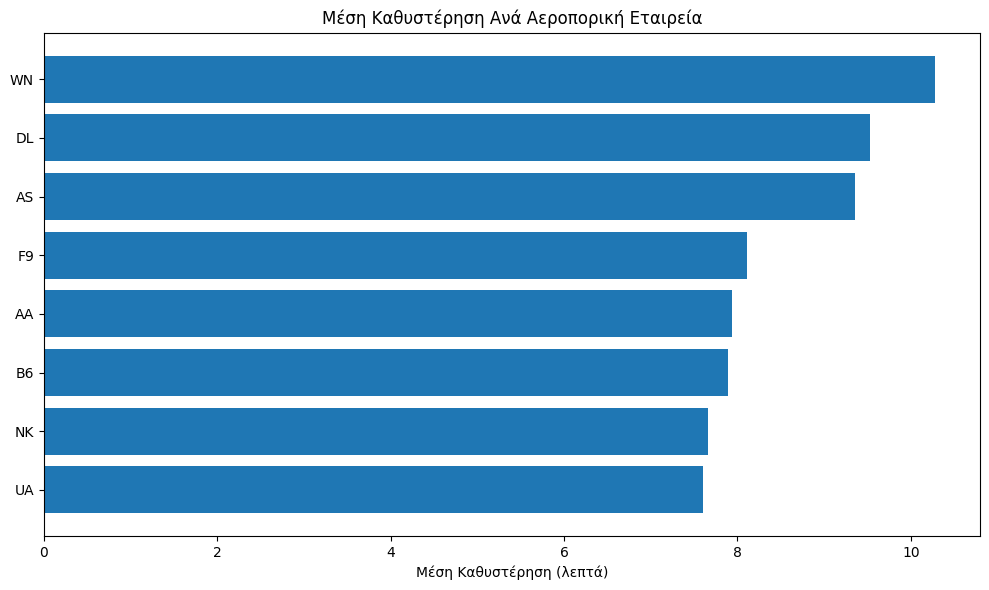

In [45]:
airline_avg = (
    clean_df.groupBy("AIRLINE")
            .agg(avg("DEP_DELAY").alias("avg_delay"))
            .orderBy(col("avg_delay").desc())
)

air_pdf = airline_avg.toPandas()

plt.figure(figsize=(10,6))
plt.barh(air_pdf["AIRLINE"], air_pdf["avg_delay"])
plt.gca().invert_yaxis()
plt.xlabel("Μέση Καθυστέρηση (λεπτά)")
plt.title("Μέση Καθυστέρηση Ανά Αεροπορική Εταιρεία")
plt.tight_layout()
plt.show()


**Σύντομος σχολιασμός**

Η κατανομή των καθυστερήσεων ανά αεροπορική εταιρεία δείχνει ότι ορισμένες εταιρείες παρουσιάζουν πιο συστηματικά υψηλές καθυστερήσεις σε σχέση με άλλες. Πιθανές αιτίες περιλαμβάνουν διαφορετικές επιχειρησιακές πολιτικές, μεγέθη στόλου, κίνηση στα hub αεροδρόμια και ποιότητα συντονισμού. Η οπτικοποίηση βοηθά στον εντοπισμό εταιρειών με προβληματικές επιδόσεις και μπορεί να αποτελέσει βάση για περαιτέρω επιχειρησιακή αξιολόγηση.

**Heatmap routes vs delay**

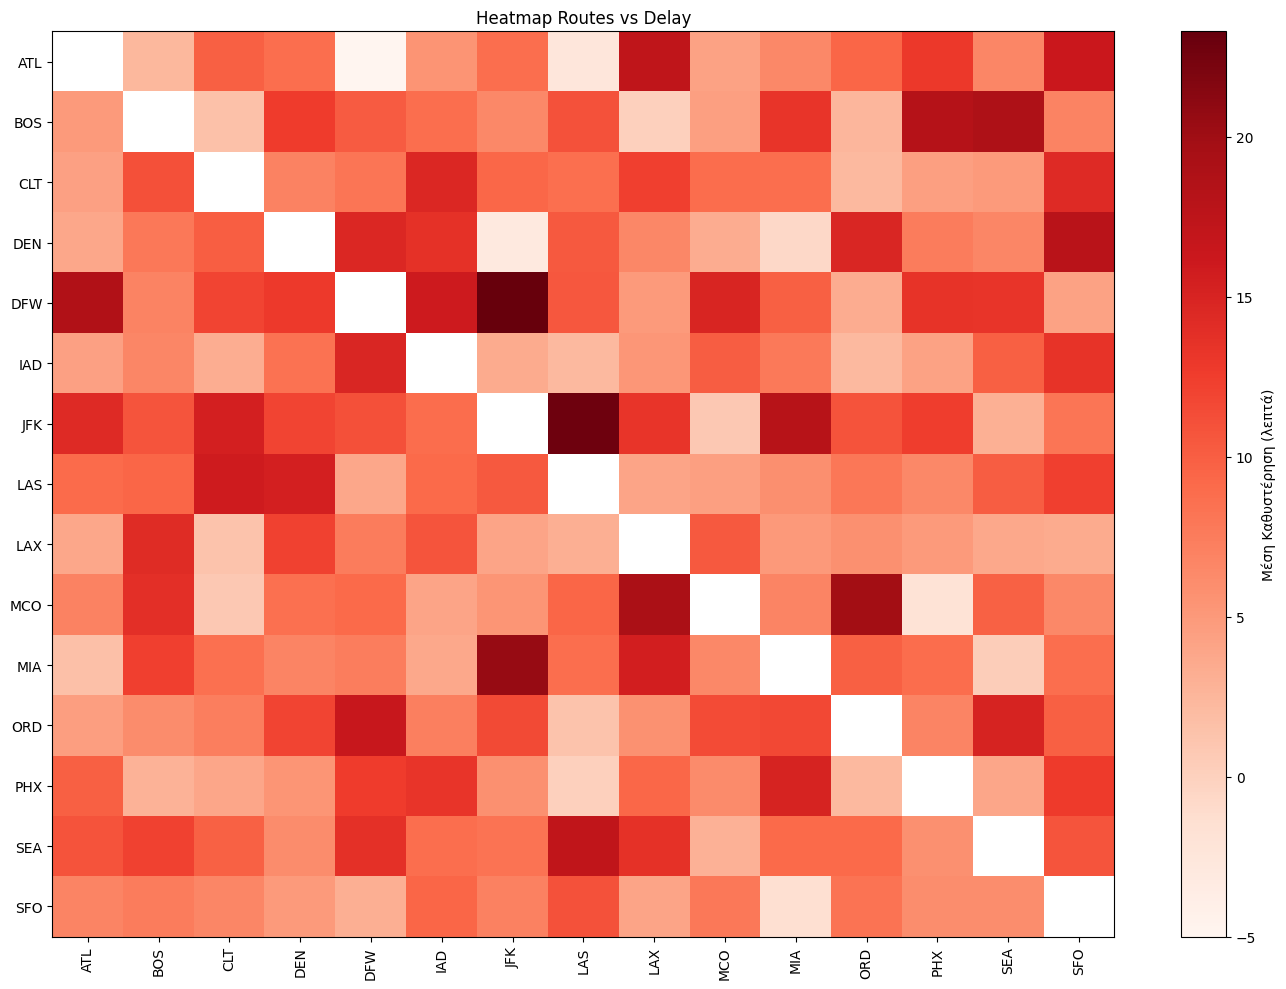

In [46]:
import numpy as np

heat_pdf = route_avg.toPandas()

pivot_df = heat_pdf.pivot(
    index="ORIGIN_AIRPORT",
    columns="DEST_AIRPORT",
    values="avg_delay"
)

plt.figure(figsize=(14,10))
plt.imshow(pivot_df, cmap="Reds", aspect="auto")
plt.colorbar(label="Μέση Καθυστέρηση (λεπτά)")
plt.title("Heatmap Routes vs Delay")
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=90)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.tight_layout()
plt.show()


**Σύντομος σχολιασμός**

Το heatmap αποκαλύπτει ποια ζευγάρια αεροδρομίων παρουσιάζουν συστηματικά υψηλότερες καθυστερήσεις. Οι πιο κόκκινες περιοχές αντιστοιχούν σε routes με αυξημένη συμφόρηση ή προβλήματα επιχειρησιακής φύσης. Η οπτικοποίηση αυτή επιτρέπει τον άμεσο εντοπισμό προβληματικών δρομολογίων σε μορφή πίνακα, σε αντίθεση με τα απλά bar charts που εμφανίζουν μόνο τα top‐10.